## Functions to grab features from a directory

In [1]:
import os
import numpy as np

def feature_from_file(file_path, feature_type="head", byte_num=512): # will add more feature_type later
    """Retreives features from a file.
  
    Parameters:
    feature_type (str): "head" to get bytes from head of the file.
    byte_num (int): Number of bytes to grab.
    file_path (str): File path of file to get features from.
    
    Returns:
    List of bytes from file_path. 
    """
    with open(file_path, 'rb') as f:
        byte = f.read(1)
        index = 1
        features = []
    
        while byte and index <= byte_num:
            features.append(byte)
            index += 1
            byte = f.read(1)
        
        if len(features) < byte_num:
            features.extend([b'' for i in range(byte_num - len(features))])

        assert len(features) == byte_num
        return features

def feature_from_dir(dir_path, feature_type="head", byte_num=512):
    """Takes a directory and grabs features from each file.
    
    Parameters:
    dir_path (str): Path of directory to take features from.
    feature_type (str): Type of features to get.
    byte_num (str): Number of features to take
    
    Return:
    features (list): List containing a list of byte_num bytes from each fie in dir_path.
    """
    features = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        for filename in filenames:
            features.append(feature_from_file(os.path.join(dirpath, filename), feature_type, byte_num))
    
    return features

def translate_bytes(dir_features):
    """Translates bytes into integers.
    
    Parameter:
    dir_features (list): List containing lists of bytes.
    
    Return:
    translated_features (numpy array): dir_features with bytes translated to integers.
    """
    translated_features = np.zeros((len(dir_features), len(dir_features[0])))
    
    for idx, file_features in enumerate(dir_features):
        translated_features[idx] = np.array([int.from_bytes(c, byteorder="big") for c in file_features])
    
    return translated_features

## Feature preprocessing

In [2]:
from sklearn.model_selection import train_test_split

test_set_dir = '/Users/ryan/Documents/CS/CDAC/official_xtract/sampler_dataset/pub8'

raw_features = feature_from_dir(test_set_dir, byte_num=512)
untranslated_features = translate_bytes(raw_features)
x = untranslated_features / 255

x_train, x_test, _, _ = train_test_split(x, x)

print(raw_features[0])
print(untranslated_features[0])
print(x[0])

[b'S', b'O', b'C', b'A', b'T', b' ', b'd', b'a', b't', b'a', b' ', b'r', b'e', b'p', b'o', b'r', b't', b' ', b'c', b'r', b'e', b'a', b't', b'e', b'd', b':', b' ', b'2', b'0', b'1', b'5', b'-', b'1', b'0', b'-', b'2', b'8', b' ', b'1', b'9', b':', b'1', b'4', b' ', b'+', b'0', b'0', b'0', b'0', b'\n', b'D', b'O', b'I', b' ', b'o', b'f', b' ', b't', b'h', b'e', b' ', b'e', b'n', b't', b'i', b'r', b'e', b' ', b'S', b'O', b'C', b'A', b'T', b' ', b'c', b'o', b'l', b'l', b'e', b'c', b't', b'i', b'o', b'n', b':', b' ', b'1', b'0', b'.', b'1', b'5', b'9', b'4', b'/', b'P', b'A', b'N', b'G', b'A', b'E', b'A', b'.', b'8', b'4', b'9', b'7', b'7', b'0', b'\n', b' ', b' ', b' ', b' ', b'o', b'r', b' ', b's', b'e', b'e', b':', b' ', b'h', b't', b't', b'p', b':', b'/', b'/', b'd', b'o', b'i', b'.', b'p', b'a', b'n', b'g', b'a', b'e', b'a', b'.', b'd', b'e', b'/', b'1', b'0', b'.', b'1', b'5', b'9', b'4', b'/', b'P', b'A', b'N', b'G', b'A', b'E', b'A', b'.', b'8', b'4', b'9', b'7', b'7', b'0', b'\n', 

In [15]:
from keras.optimizers import SGD, Adadelta
sgd_optimizer = SGD(lr=1, decay=0.001)
adadelta_optimizer = Adadelta(lr=0.1, decay=-0.01)

## Keras model

In [3]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense

input_size = len(x_train[0])

input_layer = Input((input_size,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense (64, activation='relu')(encoded)
decoded = Dense(input_size, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

history = autoencoder.fit(x_train, x_train,
                          epochs=100,
                          batch_size = 256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

print(K.eval(autoencoder.optimizer.lr))

Using TensorFlow backend.
W1007 21:44:26.125338 4751209920 deprecation_wrapper.py:119] From /Users/ryan/.conda/envs/official_xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1007 21:44:26.135404 4751209920 deprecation_wrapper.py:119] From /Users/ryan/.conda/envs/official_xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1007 21:44:26.138383 4751209920 deprecation_wrapper.py:119] From /Users/ryan/.conda/envs/official_xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1007 21:44:26.173716 4751209920 deprecation_wrapper.py:119] From /Users/ryan/.conda/envs/official_xtract/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               33280     
Total params: 70,304
Trainable params: 70,304
Non-trainable params: 0
_________________________________________________________________
Train on 15321 samples, validate on 5107 samples
Epoch 1/100
15321/15321 [==============================] - 1s 43us/step - loss: 0.5516 - 

15321/15321 [==============================] - 0s 26us/step - loss: 0.3774 - acc: 0.3389 - val_loss: 0.3769 - val_acc: 0.3389
Epoch 53/100
15321/15321 [==============================] - 0s 26us/step - loss: 0.3774 - acc: 0.3389 - val_loss: 0.3768 - val_acc: 0.3389
Epoch 54/100
15321/15321 [==============================] - 0s 26us/step - loss: 0.3773 - acc: 0.3389 - val_loss: 0.3767 - val_acc: 0.3389
Epoch 55/100
15321/15321 [==============================] - 0s 26us/step - loss: 0.3773 - acc: 0.3389 - val_loss: 0.3766 - val_acc: 0.3389
Epoch 56/100
15321/15321 [==============================] - 0s 26us/step - loss: 0.3772 - acc: 0.3389 - val_loss: 0.3765 - val_acc: 0.3389
Epoch 57/100
15321/15321 [==============================] - 0s 26us/step - loss: 0.3771 - acc: 0.3389 - val_loss: 0.3765 - val_acc: 0.3389
Epoch 58/100
15321/15321 [==============================] - 0s 26us/step - loss: 0.3771 - acc: 0.3389 - val_loss: 0.3764 - val_acc: 0.3389
Epoch 59/100
15321/15321 [==============

In [4]:
weights = autoencoder.get_weights()
for idx, weight in enumerate(weights):
    print("LAYER {}".format(idx))
    print(weight)

LAYER 0
[[ 0.02770511  0.20840076  0.13901624 ... -0.22429916 -0.02655648
   0.08965909]
 [-0.01120008  0.28830615  0.11001299 ...  0.09919403 -0.00479276
   0.18426345]
 [-0.03292449 -0.02589399 -0.01674716 ...  0.09799673  0.09437383
   0.05815312]
 ...
 [-0.08238504 -0.04559893  0.01158955 ... -0.07375364 -0.09019234
   0.05264566]
 [-0.13604142 -0.10572207  0.21692961 ... -0.01700942  0.00631992
  -0.08276074]
 [-0.15033086 -0.24469809 -0.16048017 ... -0.08871324  0.00324926
  -0.01033799]]
LAYER 1
[ 0.33324665  0.16894658  0.36436534 -0.2820532   0.3112829  -0.34924823
  0.66355133 -0.31188565  0.16667551  0.54794574  0.35951594  0.26423296
 -0.02087246  0.40922067  0.30514207  0.35802513  0.02284421 -0.30599037
 -0.31970474  0.55048656  0.23926361  0.09845064 -0.02014095  0.09782772
 -0.27656454  0.10414974  0.10038996 -0.0241366  -0.02669938  0.38402838
  0.9365611   0.2565795   0.6793131   0.33182502  0.49004602  0.5530113
 -0.25547537  0.03878358  0.12784885  0.14432849  0.058

In [7]:
autoencoder.save('crappy_model.h5')

## Results visualization

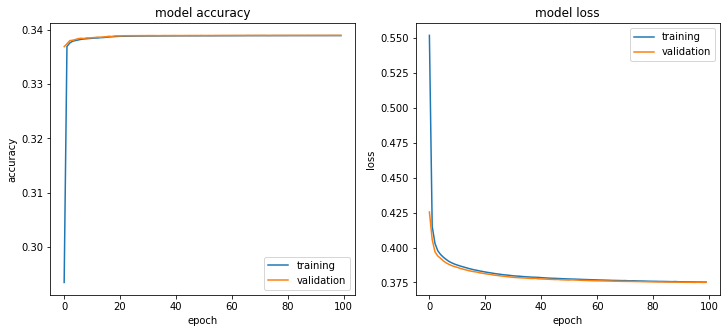

In [6]:
%%capture --no-display 
import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)